In [2]:
import os
import pickle
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors, BallTree, kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
from torch_geometric.data import Data, Dataset, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import SAGEConv, BatchNorm, LayerNorm, global_mean_pool, global_max_pool
from torch.cuda.amp import autocast, GradScaler
from warmup_scheduler import GradualWarmupScheduler
from tqdm import tqdm


h5_file = 'quark-gluon_data-set_n139306.hdf5'

with h5py.File(h5_file, 'r') as f:
    X_jets = f['X_jets'][:]  
    y = f['y'][:].astype(np.int64) 

print("X_jets shape:", X_jets.shape)
print("y shape:", y.shape)

X_jets shape: (139306, 125, 125, 3)
y shape: (139306,)


In [3]:
def split(data, batch):

    node_slice = torch.cumsum(torch.from_numpy(np.bincount(batch)), 0)
    node_slice = torch.cat([torch.tensor([0]), node_slice])
    data.__num_nodes__ = torch.bincount(batch).tolist()

    slices = {
        'x': node_slice,
        'y': torch.tensor([0], dtype=torch.long),
        'edge_index': torch.tensor([0], dtype=torch.long),
        'edge_attr': torch.tensor([0], dtype=torch.long)
    }

    if data.y is not None:
        if data.y.size(0) == batch.size(0):
            slices['y'] = node_slice
        else:
            slices['y'] = torch.arange(0, batch[-1] + 2, dtype=torch.long)

    return data, slices

scaler_ecal = StandardScaler()
scaler_hcal = StandardScaler()
scaler_tracks = StandardScaler()

def fit_global_scalers(X_jets):

    global scaler_ecal, scaler_hcal, scaler_tracks
    
    all_points = []

    for img in tqdm(X_jets):
        mask = np.any(img > 1e-3, axis=2) 
        y_coords, x_coords = np.nonzero(mask)  
        
        if len(y_coords) > 0:  
            all_points.append(img[y_coords, x_coords, :])  

    all_points = np.vstack(all_points)

    scaler_ecal.fit(all_points[:, 0].reshape(-1, 1))
    scaler_hcal.fit(all_points[:, 1].reshape(-1, 1))
    scaler_tracks.fit(all_points[:, 2].reshape(-1, 1))
    
    print("Global scalers fitted!")

def normalize_point_cloud(points):

    points_norm = np.copy(points)
    points_norm[:, 0] = scaler_ecal.transform(points[:, 0].reshape(-1, 1)).flatten()
    points_norm[:, 1] = scaler_hcal.transform(points[:, 1].reshape(-1, 1)).flatten()
    points_norm[:, 2] = scaler_tracks.transform(points[:, 2].reshape(-1, 1)).flatten()
    return points_norm

def image_to_point_cloud(image):
    mask = np.sum(image, axis=2) > 0 
    y_coords, x_coords = np.nonzero(mask) 
    features = image[y_coords, x_coords, :] 
    points = np.hstack((features, x_coords[:, None], y_coords[:, None]))  
    points = normalize_point_cloud(points)  

    return points.astype(np.float32)

def point_cloud_to_graph(points, k=5):

    num_nodes = points.shape[0]

    k_eff = max(2, min(k + 1, num_nodes))

    tree = BallTree(points[:, -2:])  
    distances, indices = tree.query(points[:, -2:], k=k_eff)

    neighbors = indices[:, 1:] 
    
    delta_features = points[neighbors, :-2] - points[:, None, :-2]
    delta_features = delta_features.reshape(-1, 3)

    dist_vals = distances[:, 1:].reshape(-1, 1)  

    edge_attr = np.hstack((dist_vals, delta_features)).astype(np.float32)

    source_nodes = np.repeat(np.arange(num_nodes), k_eff - 1) 
    edge_index = np.stack((source_nodes, neighbors.reshape(-1)), axis=0).astype(np.int32)

    return points, edge_index, edge_attr

def read_graph(X_jets, y, k=5):

    x_list = []
    edge_index_list = []
    edge_attr_list = []
    node_graph_id_list = []
    y_list = []

    num_nodes_list = []
    num_edges_list = []

    for img_idx, img in enumerate(tqdm(X_jets)):
        points = image_to_point_cloud(img)

        vertices, img_edge_index, img_edge_attr = point_cloud_to_graph(points, k=k)
        x_list.append(vertices)
        edge_index_list.append(img_edge_index)
        edge_attr_list.append(img_edge_attr)
        node_graph_id_list.append(np.full(vertices.shape[0], img_idx, dtype=np.int32))
        y_list.append(y[img_idx].reshape(1, -1))

        num_nodes_list.append(vertices.shape[0])
        num_edges_list.append(img_edge_index.shape[1])

    x = np.vstack(x_list) 
    edge_index = np.hstack(edge_index_list) 
    edge_attr = np.vstack(edge_attr_list)  
    node_graph_id = np.concatenate(node_graph_id_list) 
    y_data = np.vstack(y_list) 

    x = torch.from_numpy(x).to(torch.float32).pin_memory()
    edge_index = torch.from_numpy(edge_index).to(torch.int64).pin_memory()
    edge_attr = torch.from_numpy(edge_attr).to(torch.float32).pin_memory()
    y_data = torch.from_numpy(y_data).to(torch.float32).pin_memory()
    node_graph_id = torch.from_numpy(node_graph_id).to(torch.int64).pin_memory()

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y_data)
    
    data, slices = split(data, node_graph_id)

    edge_slice = np.concatenate(([0], np.cumsum(num_edges_list)))  
    slices['edge_index'] = torch.from_numpy(edge_slice).to(torch.int32)
    slices['edge_attr'] = torch.from_numpy(edge_slice).to(torch.int32)

    return data, slices


In [4]:
graph_file = "jet_graphs.pkl"

if os.path.exists(graph_file):
    with open(graph_file, "rb") as f:
        data, slices = pickle.load(f)
    print("Loaded preprocessed graphs from file!")
else:   
    fit_global_scalers(X_jets)
    data, slices = read_graph(X_jets, y, k=5)
    
    with open(graph_file, "wb") as f:
        pickle.dump((data, slices), f)
    print("Graph dataset processed and saved!")

100%|██████████| 139306/139306 [00:44<00:00, 3157.49it/s]


Global scalers fitted!


100%|██████████| 139306/139306 [07:48<00:00, 297.39it/s]


Graph dataset processed and saved!


In [5]:
class JetGraphDataset(InMemoryDataset):
    def __init__(self, graph_file, transform=None, pre_transform=None):
        super(JetGraphDataset, self).__init__(None, transform, pre_transform)
    
        if os.path.exists(graph_file):
            with open(graph_file, "rb") as f:
                loaded = pickle.load(f)
            
            assert isinstance(loaded, tuple) and len(loaded) == 2
            
            self.data, self.slices = loaded 

    def len(self):
        assert self.slices is not None
        return len(self.slices['x']) - 1 

dataset = JetGraphDataset(graph_file=graph_file)

train_idx, test_idx = train_test_split(
    np.arange(len(dataset)), test_size=0.2, stratify=dataset.data.y.numpy()
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.125, stratify=dataset.data.y.numpy()[train_idx]
)

train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for batch in train_loader:
    print(f"Batch x shape: {batch.x.shape}")
    print(f"Batch edge_index shape: {batch.edge_index.shape}")
    print(f"Batch y shape: {batch.y.shape}")
    break 

/beegfs/home/anning/.conda/envs/qenv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/beegfs/home/anning/.conda/envs/qenv/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Batch x shape: torch.Size([22423, 5])
Batch edge_index shape: torch.Size([2, 112115])
Batch y shape: torch.Size([32, 1])


In [6]:
class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes, dropout=0.3):
        super(GraphSAGE, self).__init__()

        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.norm1 = LayerNorm(hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.norm2 = LayerNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.norm3 = LayerNorm(hidden_channels)
        self.conv4 = SAGEConv(hidden_channels, hidden_channels)
        self.norm4 = LayerNorm(hidden_channels)
        self.conv5 = SAGEConv(hidden_channels, hidden_channels)  
        self.norm5 = LayerNorm(hidden_channels)

        self.lin = nn.Linear(hidden_channels, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, batch):
        
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = F.relu(x)

        x_res = x 
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = F.relu(x + x_res) 
        
        x_res = x  
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = F.relu(x + x_res)  

        x_res = x  
        x = self.conv4(x, edge_index)
        x = self.norm4(x)
        x = F.relu(x + x_res)  

        x_res = x  
        x = self.conv5(x, edge_index)
        x = self.norm5(x)
        x = F.relu(x + x_res)  
        x = self.dropout(x)

        x = global_mean_pool(x, batch) #max

        x = self.lin(x)

        return x


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(
    in_channels=5,        
    hidden_channels=256,
    num_classes=2,
    dropout=0.3
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-5)

base_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=5e-6)
scheduler = GradualWarmupScheduler(optimizer, multiplier=1.0, total_epoch=10, after_scheduler=base_scheduler)

In [8]:
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []
best_val_acc = 0 
scaler = GradScaler()

def train():
    model.train()
    total_loss, correct, total = 0, 0, 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        with autocast():
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y.view(-1).long())  

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        pred = out.argmax(dim=1)
        correct += (pred == data.y.view(-1)).sum().item()
        total += data.y.size(0)

    return total_loss / len(train_loader), correct / total

def evaluate(loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            loss = F.cross_entropy(out, data.y.view(-1).long())
            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == data.y.view(-1)).sum().item()
            total += data.y.size(0)

    return total_loss / len(loader), correct / total

Epoch 1/100, Train Loss: 0.8666, Train Acc: 0.5000, Val Loss: 0.8673, Val Acc: 0.5000, Test Loss: 0.8663, Test Acc: 0.5000
Epoch 2/100, Train Loss: 0.6958, Train Acc: 0.5151, Val Loss: 0.6880, Val Acc: 0.5488, Test Loss: 0.6879, Test Acc: 0.5534
Epoch 3/100, Train Loss: 0.6709, Train Acc: 0.5765, Val Loss: 0.6195, Val Acc: 0.6857, Test Loss: 0.6163, Test Acc: 0.6840
Epoch 4/100, Train Loss: 0.6178, Train Acc: 0.6751, Val Loss: 0.6132, Val Acc: 0.6749, Test Loss: 0.6106, Test Acc: 0.6757
Epoch 5/100, Train Loss: 0.6146, Train Acc: 0.6772, Val Loss: 0.6077, Val Acc: 0.6862, Test Loss: 0.6060, Test Acc: 0.6843
Epoch 6/100, Train Loss: 0.6109, Train Acc: 0.6816, Val Loss: 0.6073, Val Acc: 0.6773, Test Loss: 0.6073, Test Acc: 0.6767
Epoch 7/100, Train Loss: 0.6070, Train Acc: 0.6845, Val Loss: 0.6016, Val Acc: 0.6966, Test Loss: 0.6008, Test Acc: 0.6936
Epoch 8/100, Train Loss: 0.6033, Train Acc: 0.6881, Val Loss: 0.5978, Val Acc: 0.6886, Test Loss: 0.5976, Test Acc: 0.6880
Epoch 9/100, Tra

/beegfs/home/anning/.conda/envs/qenv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:855: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 11/100, Train Loss: 0.5940, Train Acc: 0.6972, Val Loss: 0.6073, Val Acc: 0.7018, Test Loss: 0.6079, Test Acc: 0.6975
Epoch 12/100, Train Loss: 0.5932, Train Acc: 0.6985, Val Loss: 0.5882, Val Acc: 0.7057, Test Loss: 0.5917, Test Acc: 0.7002
Epoch 13/100, Train Loss: 0.5916, Train Acc: 0.6991, Val Loss: 0.5878, Val Acc: 0.7055, Test Loss: 0.5908, Test Acc: 0.6988
Epoch 14/100, Train Loss: 0.5911, Train Acc: 0.6992, Val Loss: 0.5908, Val Acc: 0.6966, Test Loss: 0.5938, Test Acc: 0.6917
Epoch 15/100, Train Loss: 0.5911, Train Acc: 0.6989, Val Loss: 0.5868, Val Acc: 0.7003, Test Loss: 0.5873, Test Acc: 0.6999
Epoch 16/100, Train Loss: 0.5907, Train Acc: 0.6999, Val Loss: 0.5893, Val Acc: 0.7003, Test Loss: 0.5894, Test Acc: 0.6974
Epoch 17/100, Train Loss: 0.5894, Train Acc: 0.7018, Val Loss: 0.5922, Val Acc: 0.6860, Test Loss: 0.5939, Test Acc: 0.6867
Epoch 18/100, Train Loss: 0.5896, Train Acc: 0.7005, Val Loss: 0.5886, Val Acc: 0.7061, Test Loss: 0.5898, Test Acc: 0.7002
Epoch 19

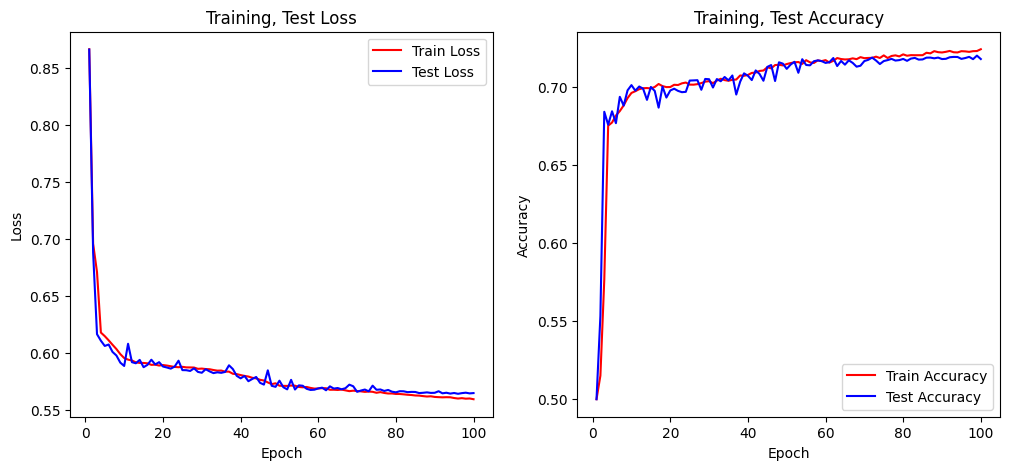

In [9]:
num_epochs = 100 #80
for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_loss, val_acc = evaluate(val_loader)
    test_loss, test_acc = evaluate(test_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model2.pth")
    
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")


model.load_state_dict(torch.load("best_model2.pth"))
final_test_loss, final_test_acc = evaluate(test_loader)
print(f"\n Final Test Accuracy: {final_test_acc:.4f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", color='red', linewidth=1.5)
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss", color='blue', linewidth=1.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy", color='red', linewidth=1.5)
plt.plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy", color='blue', linewidth=1.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training, Test Accuracy")
plt.legend()

plt.show()